------
# <b>TP5 - ALTEGRAD - 2023 - Deep Learning for Graphs (1/2)</b>
## MARENGO Matteo | matteo.marengo@ens-paris-saclay.fr
## <b>PART 2 - Graph Neural Networks</b>
------

# <b>3.1 - Implementation of Graph Neural Network</b>

## <b>3.1.a - Utils function</b>
### <b>TASK 9</b>

In [12]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
MARENGO Matteo
matteo.marengo@ens-paris-saclay.fr
SCRIPT 1/4 - UTILS
"""

import scipy.sparse as sp
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder

def normalize_adjacency(A):
    ############## Task 9

    ##################
    # your code here #
    
    n = A.shape[0]
    A += sp.identity(n)
    degs = A.dot(np.ones(n))
    inv_degs = np.power(degs, -1./2)
    D_inv = sp.diags(inv_degs)
    A_normalized = D_inv.dot(A).dot(D_inv)  
    ##################
    return A_normalized


def load_cora():
    idx_features_labels = np.genfromtxt("../data/cora.content", dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    features = features.todense()
    features /= features.sum(1).reshape(-1, 1)
    
    class_labels = idx_features_labels[:, -1]
    le = LabelEncoder()
    class_labels = le.fit_transform(class_labels)

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("../data/cora.cites", dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())), dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])), shape=(class_labels.size, class_labels.size), dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    print('Dataset has {} nodes, {} edges, {} features.'.format(adj.shape[0], edges.shape[0], features.shape[1]))

    return features, adj, class_labels


def sparse_to_torch_sparse(M):
    """Converts a sparse SciPy matrix to a sparse PyTorch tensor"""
    M = M.tocoo().astype(np.float32)
    indices = torch.from_numpy(np.vstack((M.row, M.col)).astype(np.int64))
    values = torch.from_numpy(M.data)
    shape = torch.Size(M.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


## <b>3.1.b - Models function</b>
### <b>TASK 10</b>

In [13]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
MARENGO Matteo
matteo.marengo@ens-paris-saclay.fr
SCRIPT 2/4 - MODELS
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Tasks 10 and 13
        

        ##################
        z0 = self.fc1(x_in)
        z0 = self.relu(torch.mm(adj, z0))
        z0 = self.dropout(z0)

        z1 = self.fc2(z0)
        z1 = self.relu(torch.mm(adj, z1))

        x = self.fc3(z1)
        
        return F.log_softmax(x, dim=1)


#### <b>BONUS - MATRICES COMPUTATIONS - Question 4</b>

In [14]:
# FOR QUESTION 4 

# S4 graph
print("Z1 & Z0 for S4 graph")

X = np.array([1, 1, 1, 1])
X = X.reshape(4, 1)

W0 = np.array([0.5, -0.2])
W0 = W0.reshape(1, 2)

W1 = np.array([[0.3, -1.1], [-0.4, 0.6], [0.8, -0.1], [0.5, 0.7]])
W1 = W1.T

# adjacency matrix for S4 graph
A = np.array([[1, 1, 1, 1], [1, 1, 0, 0], [1, 0, 1, 0], [1, 0, 0, 1]])

degs = np.dot(A, np.ones(4))

inv_degs = np.power(degs, -1./2)
D_inv = np.diag(inv_degs)

A_normalized = np.dot(np.dot(D_inv, A), D_inv)


# do z0 = A_normalized * X 
z0 = A_normalized @ X
z0 = z0 @ W0
# relu(z0)
z0 = np.maximum(z0, 0)
print("")
print('Final matrix Z0:')
print("")
print(z0)

# do z1 = A_normalized * z0
z1 = A_normalized @ z0
z1 = z1 @ W1
# relu(z1)
z1 = np.maximum(z1, 0)
print("")
print('Final matrix Z1:')
print("")
print(z1)





Z1 & Z0 for S4 graph

Final matrix Z0:

[[0.65533009 0.        ]
 [0.4267767  0.        ]
 [0.4267767  0.        ]
 [0.4267767  0.        ]]

Final matrix Z1:

[[0.18494927 0.         0.49319805 0.30824878]
 [0.13352476 0.         0.35606602 0.22254126]
 [0.13352476 0.         0.35606602 0.22254126]
 [0.13352476 0.         0.35606602 0.22254126]]


# <b>3.2 - Node Classification</b>
## <b>TASK 11 </b>

In [15]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
MARENGO Matteo
matteo.marengo@ens-paris-saclay.fr
SCRIPT 3/4 - GNN KARATE
"""

import numpy as np
import networkx as nx
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# from utils import normalize_adjacency, sparse_to_torch_sparse
# from models import GNN

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('../data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print(G.number_of_nodes())
print(G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('../data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

############## Task 12
# Set the feature of all nodes to the same value
features = np.eye(n) # Generates node features
##################

# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()


34
78
Epoch: 001 loss_train: 0.6947 acc_train: 0.4444 time: 0.0040s
Epoch: 002 loss_train: 0.6905 acc_train: 0.5556 time: 0.0029s
Epoch: 003 loss_train: 0.6877 acc_train: 0.5556 time: 0.0018s
Epoch: 004 loss_train: 0.6844 acc_train: 0.5556 time: 0.0034s
Epoch: 005 loss_train: 0.6831 acc_train: 0.5556 time: 0.0020s
Epoch: 006 loss_train: 0.6795 acc_train: 0.5556 time: 0.0020s
Epoch: 007 loss_train: 0.6781 acc_train: 0.5556 time: 0.0032s
Epoch: 008 loss_train: 0.6683 acc_train: 0.5556 time: 0.0031s
Epoch: 009 loss_train: 0.6612 acc_train: 0.5556 time: 0.0018s
Epoch: 010 loss_train: 0.6529 acc_train: 0.5556 time: 0.0033s
Epoch: 011 loss_train: 0.6467 acc_train: 0.5556 time: 0.0025s
Epoch: 012 loss_train: 0.6313 acc_train: 0.5926 time: 0.0020s
Epoch: 013 loss_train: 0.6161 acc_train: 0.5926 time: 0.0031s
Epoch: 014 loss_train: 0.6078 acc_train: 0.7407 time: 0.0030s
Epoch: 015 loss_train: 0.5941 acc_train: 0.8519 time: 0.0020s
Epoch: 016 loss_train: 0.5850 acc_train: 0.8519 time: 0.0030s
Ep

## <b>TASK 12 - Modify the features of the nodes</b>

In [16]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
MARENGO Matteo
matteo.marengo@ens-paris-saclay.fr
SCRIPT 3/4 - GNN KARATE
"""

import numpy as np
import networkx as nx
import time
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score

# from utils import normalize_adjacency, sparse_to_torch_sparse
# from models import GNN

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 8
n_hidden_2 = 16
learning_rate = 0.01
dropout_rate = 0.1

# Loads the karate network
G = nx.read_weighted_edgelist('../data/karate.edgelist', delimiter=' ', nodetype=int, create_using=nx.Graph())
print(G.number_of_nodes())
print(G.number_of_edges())

n = G.number_of_nodes()

# Loads the class labels
class_labels = np.loadtxt('../data/karate_labels.txt', delimiter=',', dtype=np.int32)
idx_to_class_label = dict()
for i in range(class_labels.shape[0]):
    idx_to_class_label[class_labels[i,0]] = class_labels[i,1]

y = list()
for node in G.nodes():
    y.append(idx_to_class_label[node])

y = np.array(y)
n_class = 2

adj = nx.adjacency_matrix(G) # Obtains the adjacency matrix
adj = normalize_adjacency(adj) # Normalizes the adjacency matrix

############## Task 12
# Set the feature of all nodes to the same value
features = np.ones((n,1)) # Generates node features
##################

# Yields indices to split data into training and test sets
idx = np.random.RandomState(seed=42).permutation(n)
idx_train = idx[:int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transforms the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(y).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
test()


34
78
Epoch: 001 loss_train: 0.7038 acc_train: 0.4444 time: 0.0023s
Epoch: 002 loss_train: 0.6912 acc_train: 0.4444 time: 0.0027s
Epoch: 003 loss_train: 0.7101 acc_train: 0.4444 time: 0.0027s
Epoch: 004 loss_train: 0.7071 acc_train: 0.3704 time: 0.0015s
Epoch: 005 loss_train: 0.6926 acc_train: 0.5556 time: 0.0032s
Epoch: 006 loss_train: 0.6901 acc_train: 0.5556 time: 0.0030s
Epoch: 007 loss_train: 0.6877 acc_train: 0.5556 time: 0.0020s
Epoch: 008 loss_train: 0.6898 acc_train: 0.5556 time: 0.0024s
Epoch: 009 loss_train: 0.6911 acc_train: 0.5556 time: 0.0025s
Epoch: 010 loss_train: 0.6924 acc_train: 0.5556 time: 0.0020s
Epoch: 011 loss_train: 0.6916 acc_train: 0.5556 time: 0.0021s
Epoch: 012 loss_train: 0.6905 acc_train: 0.5556 time: 0.0010s
Epoch: 013 loss_train: 0.6900 acc_train: 0.5556 time: 0.0010s
Epoch: 014 loss_train: 0.6797 acc_train: 0.5556 time: 0.0024s
Epoch: 015 loss_train: 0.6779 acc_train: 0.5556 time: 0.0026s
Epoch: 016 loss_train: 0.6986 acc_train: 0.5556 time: 0.0030s
Ep

# <b>3.3 - Visualization of Node Representations</b>
## <b>TASK 13</b>


## <b>3.a - Modification of models - returns the output of the second message passing layer</b>


In [17]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
MARENGO Matteo
matteo.marengo@ens-paris-saclay.fr
SCRIPT 2/4 - MODELS
"""

import torch
import torch.nn as nn
import torch.nn.functional as F

class GNN(nn.Module):
    """Simple GNN model"""
    def __init__(self, n_feat, n_hidden_1, n_hidden_2, n_class, dropout):
        super(GNN, self).__init__()

        self.fc1 = nn.Linear(n_feat, n_hidden_1)
        self.fc2 = nn.Linear(n_hidden_1, n_hidden_2)
        self.fc3 = nn.Linear(n_hidden_2, n_class)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x_in, adj):
        ############## Tasks 10 and 13

        z0 = self.fc1(x_in)
        z0 = self.relu(torch.mm(adj, z0))
        z0 = self.dropout(z0)

        z1 = self.fc2(z0)
        z1 = self.relu(torch.mm(adj, z1))

        x = self.fc3(z1)

        return F.log_softmax(x, dim=1),z1


## <b>3.b - GNN CORA - Retrieve the representations of only the nodes of the test set</b>

Dataset has 2708 nodes, 5429 edges, 1433 features.
Epoch: 001 loss_train: 1.9320 acc_train: 0.2925 loss_val: 1.9275 acc_val: 0.3210 time: 0.0335s
Epoch: 002 loss_train: 1.9226 acc_train: 0.2937 loss_val: 1.9182 acc_val: 0.3210 time: 0.0246s
Epoch: 003 loss_train: 1.9142 acc_train: 0.2937 loss_val: 1.9088 acc_val: 0.3210 time: 0.0199s
Epoch: 004 loss_train: 1.9054 acc_train: 0.2937 loss_val: 1.8990 acc_val: 0.3210 time: 0.0221s
Epoch: 005 loss_train: 1.8961 acc_train: 0.2937 loss_val: 1.8885 acc_val: 0.3210 time: 0.0199s
Epoch: 006 loss_train: 1.8869 acc_train: 0.2937 loss_val: 1.8774 acc_val: 0.3210 time: 0.0201s
Epoch: 007 loss_train: 1.8768 acc_train: 0.2937 loss_val: 1.8649 acc_val: 0.3210 time: 0.0239s
Epoch: 008 loss_train: 1.8661 acc_train: 0.2937 loss_val: 1.8512 acc_val: 0.3210 time: 0.0237s
Epoch: 009 loss_train: 1.8550 acc_train: 0.2937 loss_val: 1.8360 acc_val: 0.3210 time: 0.0217s
Epoch: 010 loss_train: 1.8416 acc_train: 0.2937 loss_val: 1.8201 acc_val: 0.3210 time: 0.0249s

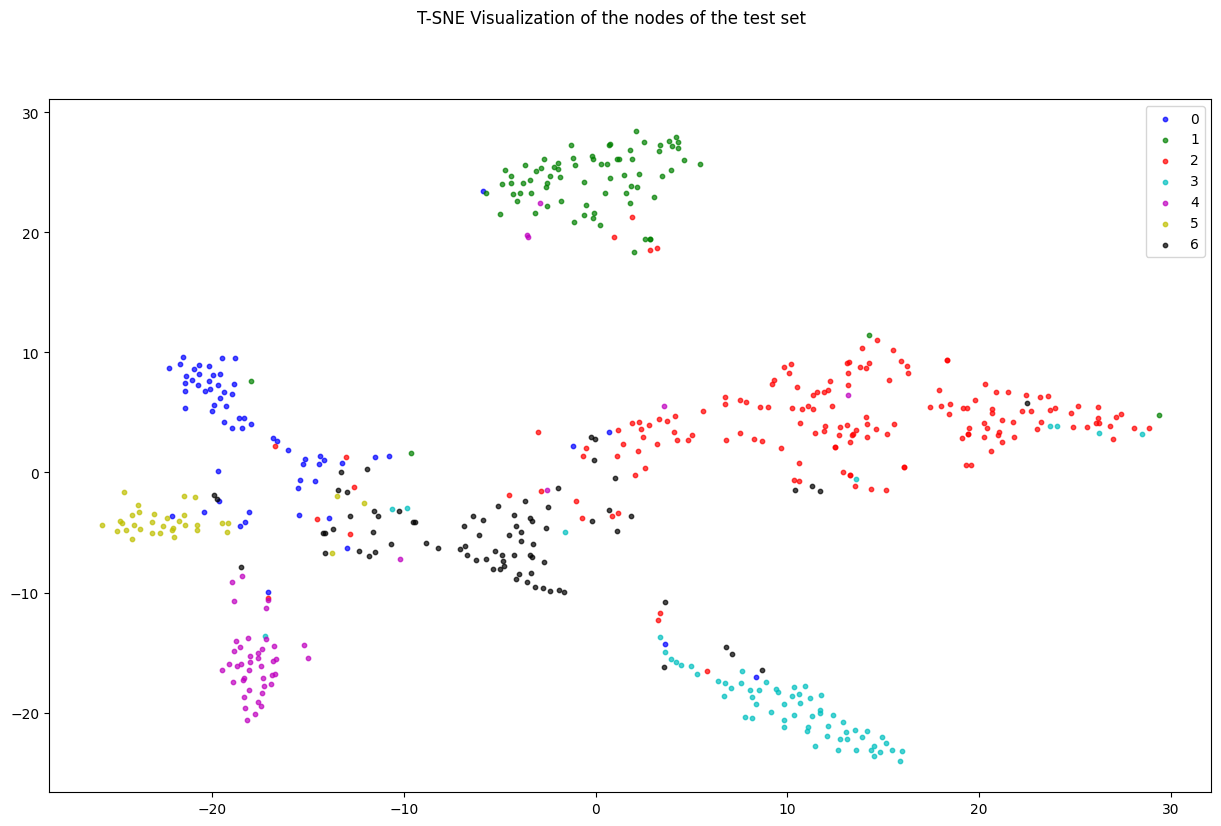

In [18]:
"""
Deep Learning on Graphs - ALTEGRAD - Nov 2023
MARENGO Matteo
matteo.marengo@ens-paris-saclay.fr
SCRIPT 4/4 - GNN CORA
"""

import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE

# from utils import load_cora, normalize_adjacency, sparse_to_torch_sparse
# from models import GNN

# Initialize device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Hyperparameters
epochs = 100
n_hidden_1 = 64
n_hidden_2 = 32
learning_rate = 0.01
dropout_rate = 0.5

# Read data
features, adj, class_labels = load_cora()
n = adj.shape[0] # Number of nodes
n_class = np.unique(class_labels).size # Number of classes

adj = normalize_adjacency(adj) # Normalize adjacency matrix

# Yields indices to split data into training, validation and test sets
idx = np.random.permutation(n)
idx_train = idx[:int(0.6*n)]
idx_val = idx[int(0.6*n):int(0.8*n)]
idx_test = idx[int(0.8*n):]

# Transform the numpy matrices/vectors to torch tensors
features = torch.FloatTensor(features).to(device)
y = torch.LongTensor(class_labels).to(device)
adj = sparse_to_torch_sparse(adj).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Creates the model and specifies the optimizer
model = GNN(features.shape[1], n_hidden_1, n_hidden_2, n_class, dropout_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


def train(epoch):
    t = time.time()
    model.train()
    optimizer.zero_grad()
    output,_ = model(features, adj)
    loss_train = F.nll_loss(output[idx_train], y[idx_train])
    acc_train = accuracy_score(torch.argmax(output[idx_train], dim=1).detach().cpu().numpy(), y[idx_train].cpu().numpy())
    loss_train.backward()
    optimizer.step()

    
    model.eval()
    output,_ = model(features, adj)

    loss_val = F.nll_loss(output[idx_val], y[idx_val])
    acc_val = accuracy_score(torch.argmax(output[idx_val], dim=1).detach().cpu().numpy(), y[idx_val].cpu().numpy())
    print('Epoch: {:03d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val),
          'time: {:.4f}s'.format(time.time() - t))


def test():
    model.eval()
    output, embeddings = model(features, adj)
    loss_test = F.nll_loss(output[idx_test], y[idx_test])
    acc_test = accuracy_score(torch.argmax(output[idx_test], dim=1).detach().cpu().numpy(), y[idx_test].cpu().numpy())
    
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test))

    return embeddings[idx_test]


# Train model
t_total = time.time()
for epoch in range(epochs):
    train(epoch)
print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
print()

# Testing
embeddings_test = test()



############## Task 13
# Transforms torch tensor to numpy matrix

##################
# your code here #
# Hint: use the .detach().cpu().numpy() methods
embeddings_test = embeddings_test.detach().cpu().numpy()
##################


# Projects the emerging representations to two dimensions using t-SNE

##################
# your code here #
tsne = TSNE(n_components=2)
embeddings_test_2d = tsne.fit_transform(embeddings_test)
##################


labels = class_labels[idx_test]
unique_labels = np.unique(labels)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

fig, ax = plt.subplots()
for i in range(unique_labels.size):
    idxs = [j for j in range(labels.size) if labels[j]==unique_labels[i]]
    ax.scatter(embeddings_test_2d[idxs,0], 
               embeddings_test_2d[idxs,1], 
               c=colors[i],
               label=i,
               alpha=0.7,
               s=10)

ax.legend(scatterpoints=1)
fig.suptitle('T-SNE Visualization of the nodes of the test set',fontsize=12)
fig.set_size_inches(15,9)
plt.show()
